# 1-stick SBI tutorial (Ball-and-Sticks, nfib=1)

This notebook walks through a minimal end-to-end example:
1. Define a single-stick parameter vector and simulate noise-free + noisy signals.
2. Sample from priors and simulate a training set at fixed SNR=20.
3. Train a Neural Posterior Estimator (SNPE-C).
4. Load brain data (or a synthetic fallback), format for inference, and run posterior sampling.
5. Visualize masks and compute error metrics using median-parameter forward predictions.

In [1]:
# Imports
import math
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt

from priors.ball_and_sticks import BallAndSticksPriorConfig, build_ball_and_sticks_priors
from models.ball_and_sticks.simulator import GradientTable, BallAndSticksAttenuation
from models.ball_and_sticks.postprocess import BallAndSticksLayout, dyads_and_dispersion_from_samples, extract_parameter_maps
from models.ball_and_sticks.export_params import export_theta_params_to_nifti
from tools.noise import NoiseConfig, apply_noise_policy, add_noise
from tools.io_nifti import load_any_array, export_any_to_nifti

from sbi.inference import SNPE_C
from sbi.utils import posterior_nn
from sbi.utils.torchutils import BoxUniform

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"  # change to "cuda" if available


/home/mszjm2/SBI_dMRI_paper/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Define a simple acquisition (bvals/bvecs) and build the simulator

We create a synthetic gradient table with **no b0s** (bvals >= 50), which the attenuation
model expects. For a real dataset, you'd load your actual bvals/bvecs and build
`GradientTable` from disk.


In [2]:
# Synthetic acquisition: single-shell, G directions
G = 60
bval = 1000.0  # s/mm^2 (single-shell)

# Random unit vectors on the sphere
rng = np.random.default_rng(seed)
vecs = rng.normal(size=(G, 3)).astype(np.float32)
vecs /= np.linalg.norm(vecs, axis=1, keepdims=True)

bvals = np.full((G,), bval, dtype=np.float32)   # bvals do not include b0, we work with normalised signals
bvecs = vecs.T  # (3, G)

# Build GradientTable and simulator

gtab = GradientTable(bvals=torch.tensor(bvals), bvecs=torch.tensor(bvecs))
simulator = BallAndSticksAttenuation(gtab=gtab, device=device)

nfib = 1
modelnum = 1
print("G:", gtab.bvals.numel())

G: 60


## 2) Example: simulate noise-free signal and add Gaussian noise at different SNR levels

For **nfib=1** and **modelnum=1**, the parameter layout is:
`[d, f1, th1, ph1]`

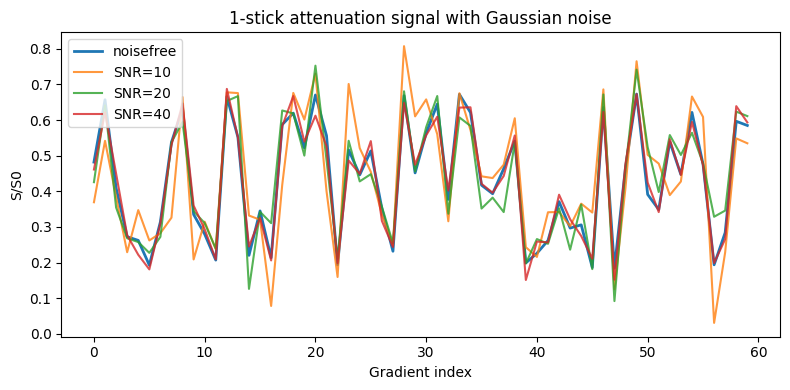

In [3]:
# Fixed (illustrative) parameters
# d (diffusivity), f1 (fraction), th1/phi1 (orientation)
theta_fixed = torch.tensor([
    1.7e-3,          # d
    0.6,             # f1
    math.pi / 3,     # theta
    math.pi / 4      # phi
], dtype=torch.float32)

# Simulate noise-free signal
x0 = simulator(theta_fixed, nfib=nfib, modelnum=modelnum).squeeze(0)

# Add Gaussian noise at different SNR levels
snr_levels = [10, 20, 40]
noisy_signals = [add_noise(x0, snr, noise_type="gaussian") for snr in snr_levels]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x0.numpy(), label="noisefree", linewidth=2)
for snr, x in zip(snr_levels, noisy_signals):
    plt.plot(x.numpy(), label=f"SNR={snr}", alpha=0.8)
plt.title("1-stick attenuation signal with Gaussian noise")
plt.xlabel("Gradient index")
plt.ylabel("S/S0")
plt.legend()
plt.tight_layout()
plt.show()

## 3) Prepare a 1-fibre, multi-shell training set (UKBiobank exemplar)

We use the **model_2** UKBiobank exemplar acquisition (already **no b0s**) to build
a **multi-shell** simulator (modelnum=2) while keeping **nfib=1** for a simple case.


In [ ]:
# Load UKBiobank exemplar (model_2) bvals/bvecs (already no b0s)
ukb_dir = Path("/home/mszjm2/SBI_UoN/Paper/Data/Brain/model_2")
bvals_path = ukb_dir / "bvals_nob0s"
bvecs_path = ukb_dir / "bvecs_nob0s"

bvals = np.genfromtxt(bvals_path).astype(np.float32)
bvecs = np.genfromtxt(bvecs_path).astype(np.float32)

# Ensure bvecs shape is (3, G)
if bvecs.shape[0] != 3 and bvecs.shape[1] == 3:
    bvecs = bvecs.T
if bvecs.shape[0] != 3:
    raise ValueError(f"bvecs must have shape (3,G) or (G,3). Got {bvecs.shape}")

# Build GradientTable and simulator for multi-shell model
gtab = GradientTable(bvals=torch.tensor(bvals), bvecs=torch.tensor(bvecs))
simulator = BallAndSticksAttenuation(gtab=gtab, device=device)

N_train = 50_000
nfib = 1
modelnum = 2  # multi-shell
G = gtab.bvals.numel()
print("G (no b0):", G)

# Build prior for nfib=1, modelnum=2
prior_cfg = BallAndSticksPriorConfig(
    nfib=nfib,
    modelnum=modelnum,
    hemisphere=True,
    include_snr=False,
    device=device,
)
prior = build_ball_and_sticks_priors(prior_cfg)

# Sample parameters and simulate noisefree signals
theta_train = prior.sample((N_train,)).to(device)
x_noisefree = simulator(theta_train, nfib=nfib, modelnum=modelnum)  # (N, G)

# Apply fixed SNR noise
noise_cfg = NoiseConfig(
    noise_type="gaussian",
    strategy="fixed",
    snr_fixed=20.0,
    snr_fixed_jitter=0.0,
    device=device,
)

x_train, snr_used = apply_noise_policy(x_noisefree, noise_cfg, base_repeat=True)

print("theta_train:", theta_train.shape)
print("x_train:", x_train.shape)


G (no b0): 100
theta_train: torch.Size([50000, 5])
x_train: torch.Size([50000, 100])


## 4) Train the NPE model (SNPE-C)

We use a small normalizing flow (NSF) for a quick tutorial run. Increase
`max_num_epochs` for higher accuracy.

In [5]:
# Prepare data
x_train = x_train.float()
theta_train = theta_train.float()

# Prior placeholder based on training min/max (matches train_snpe.py)
theta_min = theta_train.min(dim=0).values
theta_max = theta_train.max(dim=0).values
prior_box = BoxUniform(low=theta_min, high=theta_max)

# Density estimator
net = posterior_nn(model="nsf", num_transforms=5)

# Train SNPE-C
import time
t0 = time.perf_counter()

trainer = SNPE_C(
    prior=prior_box,
    density_estimator=net,
    device=device,
    show_progress_bars=True,
    logging_level="INFO",
)

density_estimator = trainer.append_simulations(theta_train, x_train).train(
    training_batch_size=512,
    max_num_epochs=50,
    learning_rate=5e-4,
    show_train_summary=True,
    use_combined_loss=True,
)

posterior = trainer.build_posterior(density_estimator)
t1 = time.perf_counter()

# --- Performance stats ---
train_time_s = t1 - t0
samples_per_sec = x_train.shape[0] / max(train_time_s, 1e-9)
time_per_epoch = train_time_s / 50
print(f"Train time: {train_time_s:.2f} s")
print(f"Time/epoch: {time_per_epoch:.2f} s")
print(f"Throughput: {samples_per_sec:.1f} samples/s")

# --- Quick posterior accuracy check on a small subset ---
@torch.no_grad()
def quick_posterior_metrics(posterior, theta_true, x_obs, n_eval=64, n_samples=200):
    n_eval = min(n_eval, x_obs.shape[0])
    idx = torch.randperm(x_obs.shape[0])[:n_eval]
    x_e = x_obs[idx]
    th_e = theta_true[idx]

    mean_params = []
    for i in range(n_eval):
        s = posterior.sample((n_samples,), x=x_e[i])
        mean_params.append(s.mean(dim=0))
    mean_params = torch.stack(mean_params, dim=0)

    mae = (mean_params - th_e).abs().mean().item()
    rmse = torch.sqrt(((mean_params - th_e) ** 2).mean()).item()
    return mae, rmse

mae, rmse = quick_posterior_metrics(posterior, theta_train, x_train, n_eval=64, n_samples=200)
print(f"Posterior mean MAE (subset):  {mae:.5f}")
print(f"Posterior mean RMSE (subset): {rmse:.5f}")


 Training neural network. Epochs trained: 51
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: 18.7023
        -------------------------
        
Train time: 206.30 s
Time/epoch: 4.13 s
Throughput: 242.4 samples/s


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]/home/mszjm2/SBI_dMRI_paper/.venv/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2264.)
  outputs, _ = torch.triangular_solve(
Drawing 200 posterior samples: 299it [00:00, 13670.72it/s]            
Drawing 200 posterior samples: 100%|██████████| 200/200 [00:00<00:00, 18087.47it/s]
Drawing 200 posterior samples: 283it [00:00, 14046.86it/s]            
Drawing 200 posterior samples: 295it [00:00, 14758.63it/s]            
Drawing 200 posterior samples: 232it [00:00, 11279.59it/s]       

Posterior mean MAE (subset):  0.07551
Posterior mean RMSE (subset): 0.22689


In [6]:
density_estimator

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=102, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=100, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=87, bias=True)
        )
      )
      (2): LULinear()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=103, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBl

In [7]:
posterior.posterior_estimator

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=102, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBlock(
              (context_layer): Linear(in_features=100, out_features=50, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): Linear(in_features=50, out_features=87, bias=True)
        )
      )
      (2): LULinear()
      (3): PiecewiseRationalQuadraticCouplingTransform(
        (transform_net): ResidualNet(
          (initial_layer): Linear(in_features=103, out_features=50, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x ResidualBl

## 4.5) Simulated recovery at multiple SNRs (1-fib vs 3-fib)

We simulate two configurations (single-fibre and 3 crossing fibres), create replicates at SNR = 3, 5, 10, 20, 40, and evaluate how well the posterior recovers the ground-truth.


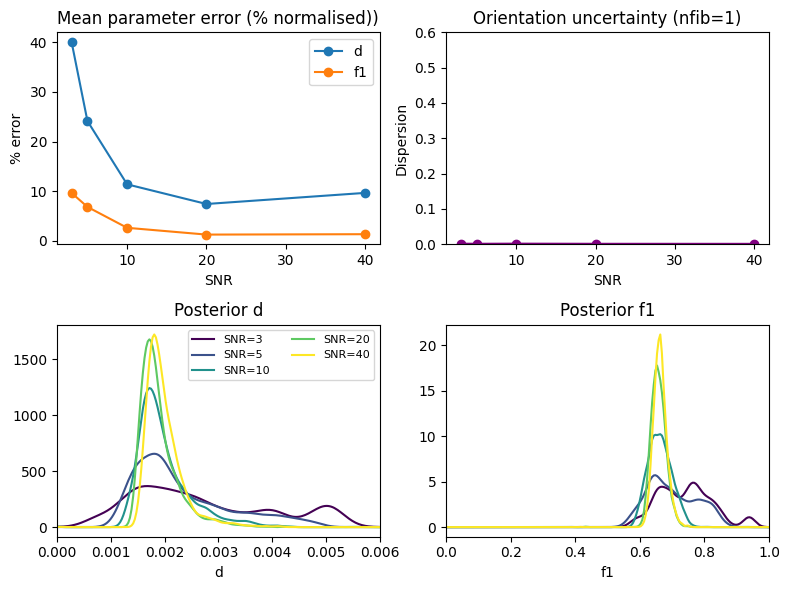

In [28]:
# --- Config ---
snr_levels = [3, 5, 10, 20, 40]
n_rep = 20  # replicates per SNR
n_post_samples = 200

# --- Ground-truth params ---
theta_1 = np.array([1.7e-3, 0.65, np.pi/3, np.pi/4, 5e-4], dtype=np.float32)
theta_3 = np.array([
    1.7e-3, 0.50, np.pi/3, np.pi/4,
    0.30,   np.pi/2, np.pi/2,
    0.15,   np.pi/3, 3*np.pi/4,
    5e-4
], dtype=np.float32)

sim_1 = simulator
sim_3 = BallAndSticksAttenuation(gtab=gtab, device=device)

# --- Helper: sample posterior with density estimator ---
@torch.no_grad()
def sample_posterior(estimator, x_obs, n_samples=200):
    x_t = torch.from_numpy(x_obs.reshape(1, -1)).float().to(device)
    s = estimator.sample(n_samples, context=x_t).cpu().numpy()
    s = np.asarray(s)
    if s.ndim == 3 and s.shape[1] == 1:
        s = s[:, 0, :]
    if s.ndim == 1:
        s = s[None, :]
    return s

# --- Run recovery experiment (1-fib estimator for BOTH cases) ---
def run_recovery(sim, theta_gt, nfib):
    out = {snr: {'mean': [], 'std': [], 'disp': [], 'samples': []} for snr in snr_levels}
    x0 = sim(torch.from_numpy(theta_gt).to(device), nfib=nfib, modelnum=2).cpu().numpy().reshape(-1)
    for snr in snr_levels:
        for _ in range(n_rep):
            x_noisy = add_noise(torch.from_numpy(x0), snr, noise_type='gaussian').numpy()
            samples = sample_posterior(density_estimator, x_noisy, n_samples=n_post_samples)
            theta_mean = samples.mean(axis=1)
            theta_std = samples.std(axis=1)
            # orientation dispersion from samples (fibre 1)
            samples_4d = samples[None, None, None, :, :]
            layout = BallAndSticksLayout(nfib=1, modelnum=2, include_snr=False)
            _dy, disp = dyads_and_dispersion_from_samples(samples_4d, layout, fibre_index=1)
            disp_val = float(np.asarray(disp).reshape(-1)[0])
            out[snr]['mean'].append(theta_mean)
            out[snr]['std'].append(theta_std)
            out[snr]['disp'].append(disp_val)
            out[snr]['samples'].append(samples)
    return out, x0

rec_1, x0_1 = run_recovery(sim_1, theta_1, nfib=1)

# --- Build single figure ---
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Row 1: percent error + orientation uncertainty
snrs = snr_levels
pe_d = []
pe_f1 = []
disp = []
for snr in snrs:
    means = np.array(rec_1[snr]['mean']).reshape(len(rec_1[5]['mean']), -1)
    pe_d.append(np.mean(100*np.abs(means[:,0] - theta_1[0]) / 0.003))
    pe_f1.append(np.mean(100*np.abs(means[:,1] - theta_1[1]) / 1.0))
    disp.append(np.mean(rec_1[snr]['disp']))
axes[0,0].plot(snrs, pe_d, '-o', label='d')
axes[0,0].plot(snrs, pe_f1, '-o', label='f1')
axes[0,0].set_xlabel('SNR')
axes[0,0].set_ylabel('% error')
axes[0,0].set_title('Mean parameter error (% normalised))')
axes[0,0].legend()

axes[0,1].plot(snrs, disp, '-o', color='purple')
axes[0,1].set_xlabel('SNR')
axes[0,1].set_ylabel('Dispersion')
axes[0,1].set_ylim(0, 0.6)
axes[0,1].set_title('Orientation uncertainty (nfib=1)')

# Row 2: KDE of posterior samples per SNR (nfib=1)
from scipy.stats import gaussian_kde
colors = plt.cm.viridis(np.linspace(0,1,len(snrs)))
for i_snr, snr in enumerate(snrs):
    samples = np.asarray(rec_1[snr]['samples'])
    # samples shape: (n_rep, n_post_samples, P)
    if samples.ndim == 3:
        samples = samples.reshape(-1, samples.shape[-1])
    elif samples.ndim == 4 and samples.shape[1] == 1:
        samples = samples[:, 0, :, :].reshape(-1, samples.shape[-1])
    if samples.ndim != 2:
        raise ValueError(f'Unexpected samples shape for KDE: {samples.shape}')
    samples = np.asarray(samples)
    if samples.ndim == 3 and samples.shape[1] == 1:
        samples = samples[:, 0, :]
    if samples.ndim != 2:
        raise ValueError(f'Unexpected samples shape for KDE: {samples.shape}')
    d_samples = np.clip(samples[:, 0].reshape(-1), 0.0, 0.006)
    f1_samples = np.clip(samples[:, 1].reshape(-1), 0.0, 1.0)
    if d_samples.size > 1 and f1_samples.size > 1:
        kde_d = gaussian_kde(d_samples)
        kde_f1 = gaussian_kde(f1_samples)
    else:
        continue
    xs_d = np.linspace(0.0, 0.006, 200)
    xs_f1 = np.linspace(0.0, 1.0, 200)
    axes[1,0].plot(xs_d, kde_d(xs_d), color=colors[i_snr], label=f'SNR={snr}')
    axes[1,1].plot(xs_f1, kde_f1(xs_f1), color=colors[i_snr], label=f'SNR={snr}')
axes[1,0].set_title('Posterior d')
axes[1,0].set_xlabel('d')
axes[1,0].set_xlim(0, 0.006)
axes[1,1].set_title('Posterior f1')
axes[1,1].set_xlabel('f1')
axes[1,1].set_xlim(0, 1)
axes[1,0].legend(fontsize=8, ncol=2)


plt.tight_layout()
plt.show()


In the plots above, we can see that:
- The higher the SNR, the lower the error recovering the ground-truth (as mean of the posterior), having the minimum at SNR=20 (it is trained at that fixed noise level)
- Given the simple configuration (1 fibre), the fibre orientation is almost 0 in any case.
- Still, we can see in the bottom row narrower posterior distributions (more confidence) as the SNR increases.

## 5) Load UKBiobank data, format it, and run inference

We load the **model_2** UKBiobank exemplar data (already normalized and **no b0s**)
and use the eroded mask to avoid problematic voxels.


In [ ]:
# UKBiobank exemplar data (already normalized, no b0s)
ukb_dir = Path("/home/mszjm2/SBI_UoN/Paper/Data/Brain/model_2")

x_path = ukb_dir / "data_norm_nob0.nii.gz"
mask_path = ukb_dir / "nodif_brain_mask_ero2.nii.gz"

if not x_path.exists():
    raise FileNotFoundError(f"Missing data file: {x_path}")
if not mask_path.exists():
    raise FileNotFoundError(f"Missing mask file: {mask_path}")

# Load data (already no b0s) and mask
x_vol = load_any_array(x_path)  # (X,Y,Z,G)
mask = load_any_array(mask_path)  # (X,Y,Z)

print("Loaded UKB data:", x_vol.shape, mask.shape)

# Ensure types
x_vol = np.asarray(x_vol, dtype=np.float32)
mask = np.asarray(mask, dtype=bool)


### Inference: posterior sampling per voxel

We flatten the masked voxels, sample from the posterior, and restore
the volume shape.
Note that we use the density estimator instead of the posterior to run inference. In this SBI version, the posterior is just a wrapper around the density estimator object. However, the latter allows for inference in batches (instead of voxel-wise) and makes inference much faster.

In [ ]:
# Optionally restrict to a single slice for speed
use_single_slice = False
slice_index = 28  # center-ish slice for this UKB exemplar
use_parallel = False
n_workers = 4
n_samples = 50

x_work = x_vol
mask_work = mask

if use_single_slice:
    z = slice_index if slice_index is not None else (x_vol.shape[2] // 2)
    z = max(0, min(z, x_vol.shape[2] - 1))
    x_work = x_vol[:, :, z : z + 1, :]
    mask_work = mask[:, :, z : z + 1]
    print(f"Using single slice z={z}")

# Flatten masked data
spatial_shape = x_work.shape[:-1]
G = x_work.shape[-1]

x_flat = x_work.reshape(-1, G)
mask_flat = mask_work.reshape(-1)

idx = np.where(mask_flat)[0]

# Optional voxel subsampling for speed
max_voxels = None  # reduce for faster demo; set to None for full slice
if max_voxels is not None and idx.size > max_voxels:
    rng = np.random.default_rng(seed)
    idx = rng.choice(idx, size=max_voxels, replace=False)
    print(f"Subsampled to {max_voxels} voxels")

x_obs = torch.from_numpy(x_flat[idx]).float().to(device)

# Sampling using the *density estimator* (faster than posterior)
@torch.no_grad()
def sample_de_per_voxel(density_estimator, x_batch, n_samples=200):
    from tqdm import tqdm
    samples_list = []
    for i in tqdm(range(x_batch.shape[0]), total=x_batch.shape[0], desc='Inference', unit='voxel'):
        # s = posterior.sample((n_samples,), x=x_batch[i])
        s = density_estimator.sample(n_samples, context=x_batch[i].unsqueeze(0)).squeeze(0)
        samples_list.append(s.cpu())
    return torch.stack(samples_list, dim=0)  # (N, n_samples, P)


# Optional multiprocessing parallelization for full brain runs
# Note: uses fork; works on Linux/Unix and CPU only.

if use_parallel:
    import multiprocessing as mp

    # Use fork so workers inherit the estimator without pickling
    ctx = mp.get_context("fork")

    _ESTIMATOR = density_estimator
    _DEVICE = device
    _N_SAMPLES = n_samples

    def _sample_one(x_vec):
        x_t = torch.from_numpy(x_vec).float().to(_DEVICE)
        # s = posterior.sample((n_samples,), x=x_batch[i])
        s = _ESTIMATOR.sample(_N_SAMPLES, context=x_t.unsqueeze(0)).squeeze(0)
        return s.cpu().numpy()

    x_np = x_obs.cpu().numpy()
    from tqdm import tqdm
    with ctx.Pool(processes=n_workers) as pool:
        samples_list = []
        for s in tqdm(pool.imap_unordered(_sample_one, [x_np[i] for i in range(x_np.shape[0])], chunksize=20), total=x_np.shape[0], desc='Inference', unit='voxel', miniters=1, mininterval=0.5):
            samples_list.append(s)
    samples_flat = torch.from_numpy(np.stack(samples_list, axis=0))
else:
    samples_flat = sample_de_per_voxel(density_estimator, x_obs, n_samples=n_samples)

# Allocate full volume and fill masked voxels
n_params = samples_flat.shape[-1]

samples_vol = torch.zeros(
    (np.prod(spatial_shape), n_samples, n_params),
    dtype=samples_flat.dtype,
)

samples_vol[idx] = samples_flat
samples_vol = samples_vol.reshape(*spatial_shape, n_samples, n_params)  # Put it back to the corresponding voxel in brain space

print("Posterior samples volume:", samples_vol.shape)


## 7) Export SBI inference NIfTI maps

We export SBI posterior summaries and sample maps in a format similar to the MCMC outputs.
If `use_single_slice=True`, the exported volumes are single-slice (X×Y×1).


In [ ]:
from models.ball_and_sticks.postprocess import BallAndSticksLayout, dyads_and_dispersion_from_samples
from models.ball_and_sticks.export_params import export_theta_params_to_nifti
from tools.io_nifti import export_any_to_nifti
# Output directory for SBI exports
sbi_out_dir = Path("/home/mszjm2/SBI_UoN/Paper/Data/Brain/model_2/Results/SBI_1fib_new")
sbi_out_dir.mkdir(parents=True, exist_ok=True)

# Reference NIfTI for geometry
ref_nifti = x_path

# Layout and samples
layout = BallAndSticksLayout(nfib=nfib, modelnum=modelnum, include_snr=False)
samples = samples_vol  # (X,Y,Z,S,P)

# Summary maps
mean_params = samples.mean(dim=3)  # (X,Y,Z,P)
std_params = samples.std(dim=3)

# Export mean/std parameter maps (per-parameter NIfTIs)
export_theta_params_to_nifti(mean_params, sbi_out_dir, nfib=nfib, modelnum=modelnum, include_snr=False, ref_nifti=ref_nifti, prefix="mean_")
export_theta_params_to_nifti(std_params, sbi_out_dir, nfib=nfib, modelnum=modelnum, include_snr=False, ref_nifti=ref_nifti, prefix="std_")

# fsum (sum of fibre fractions)
f_indices = [layout.idx_f(i) for i in range(1, nfib + 1)]
fsum_samples = samples[..., f_indices].sum(dim=-1)  # (X,Y,Z,S)
mean_fsum = fsum_samples.mean(dim=3)
std_fsum = fsum_samples.std(dim=3)
export_any_to_nifti(mean_fsum, sbi_out_dir / "mean_fsumsamples.nii.gz", ref_nifti=ref_nifti, dtype="float32")
export_any_to_nifti(std_fsum, sbi_out_dir / "std_fsumsamples.nii.gz", ref_nifti=ref_nifti, dtype="float32")

# Export merged sample maps for key params (4D: X×Y×Z×S)
def export_merged(name, idx):
    arr = samples[..., idx]  # (X,Y,Z,S)
    export_any_to_nifti(arr, sbi_out_dir / f"merged_{name}samples.nii.gz", ref_nifti=ref_nifti, dtype="float32")

export_merged('d', layout.idx_d())
export_merged('f1', layout.idx_f(1))
export_merged('th1', layout.idx_theta(1))
export_merged('ph1', layout.idx_phi(1))
if layout.has_d_std:
    export_merged('d_std', layout.idx_d_std())

# Optional: export all samples in one file (large)
export_any_to_nifti(samples, sbi_out_dir / "samples.nii.gz", ref_nifti=ref_nifti, dtype="float32")

# Dyads and dispersion (fibre 1)
dyads1, disp1 = dyads_and_dispersion_from_samples(samples, layout, fibre_index=1)
export_any_to_nifti(dyads1, sbi_out_dir / "dyads1.nii.gz", ref_nifti=ref_nifti, dtype="float32")
export_any_to_nifti(disp1, sbi_out_dir / "dyads1_dispersion.nii.gz", ref_nifti=ref_nifti, dtype="float32")

print(f"[OK] Exported SBI NIfTI maps to: {sbi_out_dir}")


## 8) Visualize masks and compute error metrics

We use the **median** of the posterior samples at each voxel, simulate forward
signals from those parameters, then compare against the observed data.

### Load MCMC results for comparison
We load mean maps (d, f1) and (optionally) posterior samples for fibre parameters.


In [ ]:
mcmc_dir = Path("/home/mszjm2/SBI_UoN/Paper/Data/Brain/model_2/Results/MCMC_ARD_1fib")

mean_d_path = mcmc_dir / "mean_dsamples.nii.gz"
mean_f1_path = mcmc_dir / "mean_f1samples.nii.gz"
dyads1_path = mcmc_dir / "dyads1.nii.gz"
dyads1_disp_path = mcmc_dir / "dyads1_dispersion.nii.gz"

# Optional posterior samples (for later distribution comparison)
merged_f1_path = mcmc_dir / "merged_f1samples.nii.gz"
merged_th1_path = mcmc_dir / "merged_th1samples.nii.gz"
merged_ph1_path = mcmc_dir / "merged_ph1samples.nii.gz"

mean_d_mcmc = load_any_array(mean_d_path)
mean_f1_mcmc = load_any_array(mean_f1_path)
dyads1_mcmc = load_any_array(dyads1_path)
dyads1_disp_mcmc = load_any_array(dyads1_disp_path)

# Optional: load posterior samples if files exist
merged_f1_mcmc = load_any_array(merged_f1_path) if merged_f1_path.exists() else None
merged_th1_mcmc = load_any_array(merged_th1_path) if merged_th1_path.exists() else None
merged_ph1_mcmc = load_any_array(merged_ph1_path) if merged_ph1_path.exists() else None

print('MCMC mean_d:', np.asarray(mean_d_mcmc).shape)
print('MCMC mean_f1:', np.asarray(mean_f1_mcmc).shape)


In [ ]:
# Visualize mean parameter maps (MCMC vs SBI)
# samples_vol shape: (X, Y, Z, n_samples, n_params)
mean_params = samples_vol.mean(dim=3).numpy()  # (X, Y, Z, P)

# Parameter indices for nfib=1, modelnum=2: [d, f1, th1, ph1, d_std]
idx_d = 0
idx_f1 = 1

# Choose slice
if use_single_slice:
    z = slice_index
else:
    z = spatial_shape[2] // 2

# Apply eroded mask to maps (set outside-mask to 0)
mask_z = mask[:, :, z] if mask.ndim == 3 else mask_work[:, :, 0]
mask_z = mask_z.astype(bool)

# MCMC maps
mcmc_d = np.asarray(mean_d_mcmc)[:, :, z]
mcmc_f1 = np.asarray(mean_f1_mcmc)[:, :, z]
mcmc_d = np.where(mask_z, mcmc_d, 0.0)
mcmc_f1 = np.where(mask_z, mcmc_f1, 0.0)

# SBI maps
sbi_d = mean_params[:, :, 0 if use_single_slice else z, idx_d]
sbi_f1 = mean_params[:, :, 0 if use_single_slice else z, idx_f1]
sbi_d = np.where(mask_z, sbi_d, 0.0)
sbi_f1 = np.where(mask_z, sbi_f1, 0.0)

# Rotate 90 degrees anti-clockwise for display
def rot_ccw(img):
    return np.rot90(img, k=1)

mcmc_d = rot_ccw(mcmc_d)
mcmc_f1 = rot_ccw(mcmc_f1)
sbi_d = rot_ccw(sbi_d)
sbi_f1 = rot_ccw(sbi_f1)
mask_r = rot_ccw(mask_z.astype(np.uint8))

# Crop to mask bounding box to reduce empty space
ys, xs = np.where(mask_r > 0)
if ys.size > 0 and xs.size > 0:
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    mcmc_d = mcmc_d[y0:y1, x0:x1]
    mcmc_f1 = mcmc_f1[y0:y1, x0:x1]
    sbi_d = sbi_d[y0:y1, x0:x1]
    sbi_f1 = sbi_f1[y0:y1, x0:x1]

# Small, tight figure with black background
fig, axes = plt.subplots(2, 2, figsize=(5.2, 4.0), facecolor='black')
for ax in axes.ravel():
    ax.set_facecolor('black')

# Row labels on the left (rotated)
fig.text(0.02, 0.73, 'MCMC', color='white', fontweight='bold', fontsize=12, rotation=90, va='center', ha='center')
fig.text(0.02, 0.28, 'SBI', color='white', fontweight='bold', fontsize=12, rotation=90, va='center', ha='center')

# Top row: MCMC
im_d = axes[0, 0].imshow(mcmc_d, cmap='gray', vmin=0.0, vmax=0.003)
axes[0, 0].set_title('mean_d', color='white', fontweight='bold', fontsize=12, pad=2)
axes[0, 0].axis('off')

im_f = axes[0, 1].imshow(mcmc_f1, cmap='gray', vmin=0.0, vmax=1.0)
axes[0, 1].set_title('mean_f1', color='white', fontweight='bold', fontsize=12, pad=2)
axes[0, 1].axis('off')

# Bottom row: SBI
axes[1, 0].imshow(sbi_d, cmap='gray', vmin=0.0, vmax=0.003)
axes[1, 0].axis('off')

axes[1, 1].imshow(sbi_f1, cmap='gray', vmin=0.0, vmax=1.0)
axes[1, 1].axis('off')

# Tighter spacing
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.10, wspace=0.005, hspace=0.02)

# Small horizontal colorbars below each column (no labels)
cax_d = fig.add_axes([0.16, 0.05, 0.33, 0.012])
cax_f = fig.add_axes([0.51, 0.05, 0.33, 0.012])
cb1 = fig.colorbar(im_d, cax=cax_d, orientation='horizontal')
cb2 = fig.colorbar(im_f, cax=cax_f, orientation='horizontal')
cb1.ax.tick_params(colors='white', labelsize=8)
cb2.ax.tick_params(colors='white', labelsize=8)
for cb in (cb1, cb2):
    cb.outline.set_edgecolor('white')

plt.show()

# Median parameters per voxel
samples_t = samples_vol
median_params = samples_t.median(dim=3).values  # (X, Y, Z, P)

# Forward prediction using median params
median_params_flat = median_params.reshape(-1, n_params)

# Only simulate for masked voxels
median_masked = median_params_flat[idx]

pred_masked = simulator(median_masked.to(device), nfib=nfib, modelnum=modelnum).cpu()

# Build full prediction volume
pred_full = torch.zeros((np.prod(spatial_shape), G), dtype=pred_masked.dtype)
pred_full[idx] = pred_masked
pred_full = pred_full.reshape(*spatial_shape, G).numpy()

# Error metrics (within mask)
obs_masked = x_flat[idx]
pred_masked_np = pred_masked.numpy()

mae = np.mean(np.abs(pred_masked_np - obs_masked))
rmse = np.sqrt(np.mean((pred_masked_np - obs_masked) ** 2))

# Normalized RMSE by mean signal magnitude
nrmse = rmse / (np.mean(np.abs(obs_masked)) + 1e-8)

print(f"MAE:   {mae:.5f}")
print(f"RMSE:  {rmse:.5f}")
print(f"NRMSE: {nrmse:.5f}")


## 9) Fixed voxel comparisons (SBI vs MCMC)

We compare two representative voxels:
- **Corpus callosum** (single-fibre expected): x=52, y=71
- **Centrum semiovale** (crossing expected): x=62, y=77

Each row shows:
1. Predicted signal vs observed (with MSE)
2. Posterior distribution of f1
3. Fibre orientation + uncertainty


In [ ]:
from scipy.stats import gaussian_kde

# Fixed voxels (x, y) on selected slice z
voxels_xy = [('Corpus callosum', 55, 72), ('Centrum semiovale', 62, 77)]
z = slice_index if use_single_slice else (spatial_shape[2] // 2)
@torch.no_grad()
def predict_signal(param_vec):
    t = torch.as_tensor(param_vec, dtype=torch.float32).to(device)
    y = simulator(t, nfib=nfib, modelnum=modelnum).cpu().numpy()
    return np.asarray(y).reshape(-1)
def get_mcmc_samples(arr, x, y, z):
    if arr is None:
        return None
    a = np.asarray(arr)
    if a.ndim == 4:
        return a[x, y, z, :]
    raise ValueError(f'Unexpected MCMC sample shape: {a.shape}')
def get_mcmc_mean_params(x, y, z):
    d = float(np.asarray(mean_d_mcmc)[x, y, z])
    f1 = float(np.asarray(mean_f1_mcmc)[x, y, z])
    th1_s = get_mcmc_samples(merged_th1_mcmc, x, y, z)
    ph1_s = get_mcmc_samples(merged_ph1_mcmc, x, y, z)
    th1 = float(np.mean(th1_s)) if th1_s is not None else 0.0
    ph1 = float(np.mean(ph1_s)) if ph1_s is not None else 0.0
    d_std = 0.0
    return np.array([d, f1, th1, ph1, d_std], dtype=np.float32)
@torch.no_grad()
def sbi_samples_for_voxel(x, y, z, n_samples=50):
    x_obs = torch.from_numpy(x_vol[x, y, z].reshape(1, -1)).float().to(device)
    expected_p = simulator.expected_param_dim(nfib=nfib, modelnum=modelnum)
    s = density_estimator.sample(n_samples, context=x_obs).cpu().numpy()
    s = np.asarray(s)
    if s.ndim == 3 and s.shape[1] == 1:
        s = s[:, 0, :]
    if s.ndim == 1:
        s = s[None, :]
    if s.ndim == 2 and s.shape[1] != expected_p and s.shape[0] == expected_p:
        s = s.T
    if s.shape[-1] != expected_p:
        raise ValueError(f'density_estimator.sample returned shape {s.shape}, expected last dim {expected_p}.')
    return s
def sph_to_cart(th, ph):
    return np.stack([np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph), np.cos(th)], axis=-1)
def orientation_stats(th_samples, ph_samples):
    th_samples = np.asarray(th_samples).reshape(-1)
    ph_samples = np.asarray(ph_samples).reshape(-1)
    v = sph_to_cart(th_samples, ph_samples)
    v_mean = v.mean(axis=0)
    norm = np.linalg.norm(v_mean) + 1e-8
    v_mean_unit = v_mean / norm
    dispersion = 1.0 - norm
    return v_mean_unit, dispersion
fig, axes = plt.subplots(len(voxels_xy), 3, figsize=(12, 6), facecolor='white', constrained_layout=False)
if len(voxels_xy) == 1:
    axes = np.expand_dims(axes, axis=0)
for row, (label, x, y) in enumerate(voxels_xy):
    obs = np.asarray(x_vol[x, y, z]).reshape(-1)
    mcmc_params = get_mcmc_mean_params(x, y, z)
    mcmc_pred = predict_signal(mcmc_params)
    sbi_samps = sbi_samples_for_voxel(x, y, z, n_samples=50)
    sbi_samps = np.asarray(sbi_samps)
    sbi_mean = sbi_samps.mean(axis=1).reshape(-1)
    sbi_pred = np.asarray(predict_signal(sbi_mean)).reshape(-1)
    mse_mcmc = np.mean((mcmc_pred - obs) ** 2)
    mse_sbi = np.mean((sbi_pred - obs) ** 2)
    ax = axes[row, 0]
    ax.plot(obs, 'k--', linewidth=2.5, label='Observed')
    ax.plot(mcmc_pred, color='dodgerblue', label=f'MCMC (MSE={mse_mcmc:.4g})')
    ax.plot(sbi_pred, color='limegreen', label=f'SBI (MSE={mse_sbi:.4g})')
    ax.set_title(f'{label} (x={x}, y={y}, z={z})', color='black', fontsize=10)
    ax.set_xlabel('Gradient index', color='black', fontsize=8)
    ax.set_ylabel('S/S0', color='black', fontsize=8)
    ax.tick_params(colors='white', labelsize=8)
    ax.legend(edgecolor='black', labelcolor='black', fontsize=7)
    ax = axes[row, 1]
    mcmc_f1 = get_mcmc_samples(merged_f1_mcmc, x, y, z)
    
    if mcmc_f1 is not None:
        mcmc_f1 = np.asarray(mcmc_f1).reshape(-1)
        mcmc_f1 = np.clip(mcmc_f1, 0.0, 1.0)
        if mcmc_f1.size > 1:
            kde = gaussian_kde(mcmc_f1)
            xs = np.linspace(0.0, 1.0, 200)
            ax.plot(xs, kde(xs), color='dodgerblue', label='MCMC')
    sbi_f1 = np.asarray(sbi_samps[:, 1]).reshape(-1)
    sbi_f1 = np.clip(sbi_f1, 0.0, 1.0)
    if sbi_f1.size > 1:
        kde = gaussian_kde(sbi_f1)
        xs = np.linspace(0.0, 1.0, 200)
        ax.plot(xs, kde(xs), color='limegreen', label='SBI')
    ax.set_title('Posterior f1', color='black', fontsize=10)
    ax.set_xlabel('f1', color='black', fontsize=8)
    ax.set_ylabel('Density', color='black', fontsize=8)
    ax.tick_params(colors='white', labelsize=8)
    ax.legend(labelcolor='black', fontsize=7)
    ax = axes[row, 2]
    v_sbi, disp_sbi = orientation_stats(sbi_samps[:, 2], sbi_samps[:, 3])
    # Samples for scatter (orientation dispersion)
    th_sbi = np.asarray(sbi_samps[:, 2]).reshape(-1)
    ph_sbi = np.asarray(sbi_samps[:, 3]).reshape(-1)
    if merged_th1_mcmc is not None and merged_ph1_mcmc is not None:
        th_m = get_mcmc_samples(merged_th1_mcmc, x, y, z)
        ph_m = get_mcmc_samples(merged_ph1_mcmc, x, y, z)
        th_m = np.asarray(th_m).reshape(-1)
        ph_m = np.asarray(ph_m).reshape(-1)
        v_mcmc, disp_mcmc = orientation_stats(th_m, ph_m)
    else:
        dy = np.asarray(dyads1_mcmc)[x, y, z]
        th_m = None
        ph_m = None
        v_mcmc = dy / (np.linalg.norm(dy) + 1e-8)
        disp_mcmc = float(np.asarray(dyads1_disp_mcmc)[x, y, z])
    v_mcmc = np.asarray(v_mcmc).reshape(-1)
    v_sbi = np.asarray(v_sbi).reshape(-1)
    # Scatter samples (lighter)
    if th_m is not None and ph_m is not None:
        v_mcmc_samples = sph_to_cart(th_m, ph_m)
        ax.scatter(v_mcmc_samples[:, 0], v_mcmc_samples[:, 1], s=6, color='dodgerblue', alpha=0.15)
    v_sbi_samples = sph_to_cart(th_sbi, ph_sbi)
    ax.scatter(v_sbi_samples[:, 0], v_sbi_samples[:, 1], s=6, color='limegreen', alpha=0.15)
    v_sbi = np.asarray(v_sbi).reshape(-1)
    if v_mcmc.size >= 2 and v_sbi.size >= 2:
        ax.arrow(0, 0, float(v_mcmc[0]), float(v_mcmc[1]), color='dodgerblue', head_width=0.08, linewidth=2.5, length_includes_head=True)
        ax.arrow(0, 0, float(v_sbi[0]), float(v_sbi[1]), color='limegreen', head_width=0.08, linewidth=2.5, length_includes_head=True)
    else:
        ax.text(0, 0, 'Orientation unavailable', color='black', fontsize=8, ha='center')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Orientation (xy) + dispersion', color='black', fontsize=10)
    ax.text(-0.95, -0.8, f'MCMC disp={disp_mcmc:.3f}', color='dodgerblue', fontsize=7)
    ax.text(-0.95, -0.95, f'SBI disp={disp_sbi:.3f}', color='limegreen', fontsize=7)
plt.subplots_adjust(left=0.06, right=0.98, top=0.93, bottom=0.08, wspace=0.35, hspace=0.35)
plt.show()
